## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
#from keras.layers import LSTM
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import pandas as pd
from keras_tqdm import TQDMNotebookCallback
import pickle
import os

/home/stjepan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data

In [2]:
# Preprocessed data (feature extraction + labels)
# config file only for info on preprocessing details

# https://drive.google.com/open?id=1ARx2M2OnHjUDXFb1Z33BZ7lBhrn0HIpn

In [3]:
features = np.load('/home/stjepan/Documents/soloact/data/processed/training_X_power.npy')

In [4]:
features.shape

(4860, 205, 1)

In [5]:
#reading labels from csv
labels = pd.read_csv("/home/stjepan/Documents/soloact/data/processed/training_Y_power.csv", delimiter=",")
#labels[:9]

In [9]:
list(labels)

['Unnamed: 0',
 'chorus.delays',
 'chorus.depths',
 'chorus.n_voices',
 'chorus.speeds',
 'group',
 'overdrive.colour',
 'overdrive.gain_db',
 'phaser.decay',
 'phaser.delay',
 'phaser.gain_in',
 'phaser.speed',
 'reverb.reverberance',
 'reverb.room_scale',
 'reverb.wet_gain',
 'model',
 'chords']

In [10]:
#our labels (2 classes)
labels[["overdrive.gain_db", "reverb.reverberance", "chorus.delays", "phaser.delay"]].head(10)

,overdrive.gain_db,reverb.reverberance,chorus.delays,phaser.delay
0,NaN,NaN,NaN,NaN
1,55.0,59.0,NaN,3.0
2,NaN,57.0,NaN,3.0
3,NaN,89.0,"[30, 54]",NaN
4,28.0,NaN,"[30, 54]",NaN
5,48.0,NaN,"[30, 54]",NaN
6,25.0,NaN,NaN,3.0
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,40.0,NaN,"[30, 54]",NaN


### Train/test split + Shuffle

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(features,labels, shuffle = True, test_size = 0.2, random_state = 44)

In [12]:
Y_train.shape

(3888, 17)

### Filtering labels from dataframe

In [14]:
Y_train_l = Y_train.filter(regex=r'chorus.del|reverb.rev|gain_db|phaser.del')
Y_val_l = Y_val.filter(regex=r'chorus.del|reverb.rev|gain_db|phaser.del')

Y_train_l[:9]

,chorus.delays,overdrive.gain_db,phaser.delay,reverb.reverberance
498,"[30, 54]",66.0,3.0,NaN
4569,"[30, 54]",61.0,NaN,NaN
61,NaN,NaN,3.0,NaN
1852,"[30, 54]",NaN,NaN,NaN
4420,"[30, 54]",28.0,NaN,73.0
1586,"[30, 54]",46.0,3.0,86.0
1438,NaN,NaN,NaN,96.0
4292,"[30, 54]",NaN,NaN,75.0
1391,"[30, 54]",NaN,NaN,NaN


### Setting up labels

In [15]:
Y_train_l2 = Y_train_l.fillna(0)
Y_val_l2 = Y_val_l.fillna(0)

Y_train_l2.columns = ["C","O","R","P"] 
Y_val_l2.columns = ["C","O","R","P"]

Y_train_l2 = Y_train_l2.where(Y_train_l2 == 0).replace(np.nan,1)
Y_val_l2 = Y_val_l2.where(Y_val_l2 == 0).replace(np.nan,1)

Y_val_l2[list("CORP")] = Y_val_l2[list("CORP")].astype(int)
Y_train_l2[list("CORP")] = Y_train_l2[list("CORP")].astype(int)


# Getting binary representation of label states (on - off)
Y_val_l2[:9]


,C,O,R,P
1097,1,0,1,0
2540,1,1,0,0
4700,1,1,1,0
1288,0,0,0,1
3754,1,1,1,1
3627,1,0,0,0
1354,0,1,0,1
3089,0,0,0,1
2846,0,1,1,0


### Concatonating effect name to its state for later comparisons of actual/predicted labels

In [16]:
labels_train = Y_train_l2.assign(labels = 'Cho__' + Y_train_l2["C"].apply(str)\
                                 +'_Ovd__' + Y_train_l2["O"].apply(str)\
                                 + '_Rev__' + Y_train_l2["R"].apply(str)\
                                 + '_Pha__' + Y_train_l2["P"].apply(str))

In [17]:
labels_val   = Y_val_l2.assign(labels = 'Cho__' + Y_val_l2["C"].apply(str)\
                               +'_Ovd__'+ Y_val_l2["O"].map(str)\
                               + '_Rev__' + Y_val_l2["R"].map(str)\
                               + '_Pha__' + Y_val_l2["P"].map(str))

In [18]:

labels_TR = labels_train["labels"]
labels_VAL = labels_val["labels"]

labels_VAL[:5]


1097    Cho__1_Ovd__0_Rev__1_Pha__0
2540    Cho__1_Ovd__1_Rev__0_Pha__0
4700    Cho__1_Ovd__1_Rev__1_Pha__0
1288    Cho__0_Ovd__0_Rev__0_Pha__1
3754    Cho__1_Ovd__1_Rev__1_Pha__1
Name: labels, dtype: object

In [19]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

Y_train_OCPR = np_utils.to_categorical(lb.fit_transform(labels_TR))
Y_val_OCPR = np_utils.to_categorical(lb.fit_transform(labels_VAL))

In [20]:
Y_train_OCPR[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [21]:
Y_val_OCPR

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

## CNN model

In [22]:
from keras import layers
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(205,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())

model2 = Sequential()
model2.add(model)
model2.add(Dense(16, activation = "softmax"))

model1 = Sequential()
model1.add(model)
model1.add(Dense(1, activation = "relu"))

opt = opt = keras.optimizers.Adam(lr=0.00001)

model1.compile(optimizer= opt, loss=['mae'], metrics =["mae"])
model2.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


### Fitting the model

In [23]:
CLASS_history = model2.fit(X_train, Y_train_OCPR, 
                            batch_size=32, 
                            epochs=60, 
                            validation_data=(X_val, Y_val_OCPR),
                            verbose=0, 
                            callbacks=[TQDMNotebookCallback()])

In [24]:
model_name = 'guitar_all_effects_on-off_lr_0.0001_60ep_dropout_0.3_PWC_4_CLASSES_5.9.2018.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

# Save model, and history

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model2.save(model_path)
print('Saved trained model at %s ' % model_path)

with open('guitar_all_effects_on-off_lr_0.0001_60ep_dropout_0.3_PWC_4_CLASSES_5.9.2018', 'wb') as file_pi:
    pickle.dump(CLASS_history.history, file_pi)
    

Saved trained model at /home/stjepan/Documents/_Krish_Suchitra_Tristan_PORTFOLIO/DL_audio/saved_models/guitar_all_effects_on-off_lr_0.0001_60ep_dropout_0.3_PWC_4_CLASSES_5.9.2018.h5 


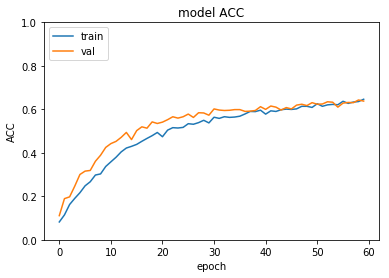

In [25]:
# Plot history

plt.plot(CLASS_history.history['acc'])
plt.plot(CLASS_history.history['val_acc'])
plt.title('model ACC')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.ylim(ymax=1)
plt.ylim(ymin=0)
plt.show()


### Predictions

In [26]:
preds = model2.predict(X_val, 
                         batch_size=32, 
                         verbose=1)

type(preds)

972/972 [==============================] - 1s 996us/step


numpy.ndarray

In [27]:
preds1=preds.argmax(axis=1)
preds1

array([ 8, 12,  6,  1, 15,  8,  5,  1,  6, 11,  1,  6,  2,  3, 12, 12,  5,
       13,  6, 14, 15, 11,  0,  7,  1,  7,  7,  2,  7,  1,  5,  2, 10,  0,
       14,  1,  5,  8,  2,  4, 11,  6, 11,  7,  6,  9,  7, 12, 11, 14,  6,
       15, 14,  7,  4,  6,  5, 15,  8, 15, 14,  6,  0, 15,  5,  5,  5, 13,
        5,  5,  0, 11, 15,  7,  6,  1, 11,  7, 10, 11,  2,  2,  3,  0,  7,
        6, 10, 10, 11,  4, 14, 10,  4, 11,  2, 11,  5,  8,  6,  5, 12,  0,
       11, 15,  6,  2, 12,  5, 12,  8,  4, 10,  5,  7, 14,  7,  2, 10, 10,
        5,  8,  0,  2,  4, 13,  1,  2,  3, 13,  1,  3,  2, 11, 10,  9,  8,
       11,  7, 11,  7,  3,  5, 11,  3,  3,  2,  7,  3,  6,  0,  8, 15, 13,
        1,  8,  7,  6,  3, 14, 13,  1,  6,  6,  8, 11, 15,  5, 11, 10,  0,
       11,  5, 11,  4,  2,  2,  7, 12, 12,  4,  3, 11,  3, 10,  3,  8, 15,
       12, 14,  8, 10,  7,  7, 10,  1,  4,  2,  3,  3,  5,  5,  6,  5, 15,
        4, 10, 14,  9, 12,  7,  4, 14, 10,  4,  5, 13,  0, 13,  7, 15,  4,
        0,  3,  0, 11, 12

In [28]:
abc = preds1.astype(int).flatten()

In [29]:
predictions = (lb.inverse_transform((abc)))

/home/stjepan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,Cho__1_Ovd__0_Rev__0_Pha__0
1,Cho__1_Ovd__1_Rev__0_Pha__0
2,Cho__0_Ovd__1_Rev__1_Pha__0
3,Cho__0_Ovd__0_Rev__0_Pha__1
4,Cho__1_Ovd__1_Rev__1_Pha__1
5,Cho__1_Ovd__0_Rev__0_Pha__0
6,Cho__0_Ovd__1_Rev__0_Pha__1
7,Cho__0_Ovd__0_Rev__0_Pha__1
8,Cho__0_Ovd__1_Rev__1_Pha__0
9,Cho__1_Ovd__0_Rev__1_Pha__1


In [31]:
actual=Y_val_OCPR.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

/home/stjepan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [32]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})

In [40]:
finaldf = actualdf.join(preddf)
all_ = finaldf.shape[0]
wrong = np.sum(finaldf.actualvalues != finaldf.predictedvalues)

print ('Wrong: ', wrong, '; All :', all_, "; Acc: ", 100 - (wrong/all_*100).round(3), "%")



Wrong:  352 ; All : 972 ; Acc:  63.786 %


In [ ]:
# Normally one would use no more than 3 different effects on el. guitar